In [1]:
from Binaries import *

### own trigger rate

In [2]:
estimates = \
[
    "/cr/users/filip/Trigger/RunProductionTest/trigger_output/nuria_all_triggers_0vem.csv",
    "/cr/users/filip/Trigger/RunProductionTest/trigger_output/nuria_all_triggers_1vem.csv",
    "/cr/users/filip/Trigger/RunProductionTest/trigger_output/nuria_all_triggers_2vem.csv",
    "/cr/users/filip/Trigger/RunProductionTest/trigger_output/nuria_all_triggers_5vem.csv",
    "/cr/users/filip/Trigger/RunProductionTest/trigger_output/nuria_all_triggers_10vem.csv",
    "/cr/users/filip/Trigger/RunProductionTest/trigger_output/nuria_all_triggers_20vem.csv"
]

### online trigger rate

In [3]:
import uproot

def calculate_start_end(station):

    starts = data['fCalibration.fStartSecond'].array()[station]
    deltas = data['fCalibration.fEndSecond'].array()[station]
    stops = starts + deltas

    return starts, stops, deltas

file = uproot.open("/cr/tempdata01/filip/iRODS/MonitoringData/mc_2022_03_17_00h00.root:SDMonCal")
StationIDs = file['SDMonCalBranch']['fLsId'].array()
data = file['fCalibration']
Nuria = StationIDs == 56
Qui_Don = StationIDs == 1744

Station = Nuria

start, stop, dt = calculate_start_end(Qui_Don)
t = ( 0.5 * (start + stop)  - 1331510418) / 3600
y = []

n_trig_online = []
deltas = data['fCalibration.fEndSecond'].array()[Station]

for j, trigger in enumerate(['fCalibration.fT2', 'fCalibration.fTotRate', 'fCalibration.fTotD', 'fCalibration.fMops']):

    if j != 1: y.append(data[trigger].array()[Station] / deltas)
    else: y.append(data[trigger].array()[Station])

n_trig_online_all = y[0] + y[1] + y[2] + y[3]

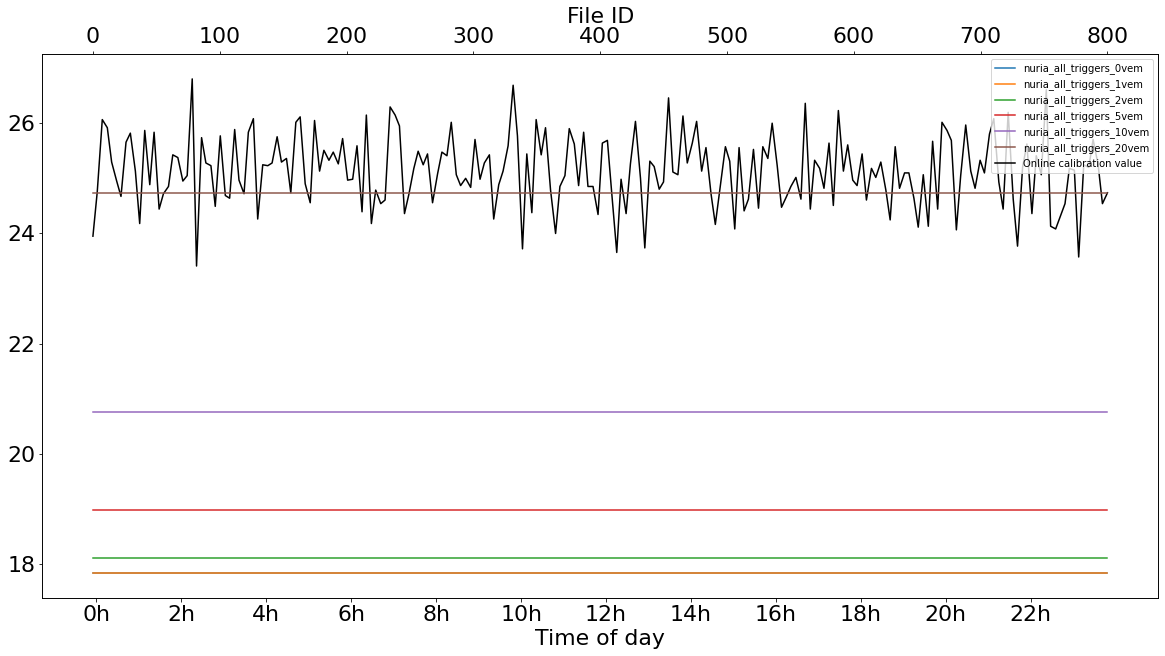

In [11]:
# Monitoring data

plt.rcParams["figure.figsize"] = [20,10]

ax1 = plt.gca()
ax1.set_xlabel("Time of day")
ax1.set_xticks(ticks = range(0, 24, 2), labels = [f"{h}h" for h in range(0, 24, 2)])
ax1.plot(t, n_trig_online_all, c = "k")

ax2 = ax1.twiny()
ax2.set_xlabel("File ID")


# Own estimate
single_trace_duration = GLOBAL.single_bin_duration * GLOBAL.n_bins

for estimate in estimates:

    duration, n_trig = np.loadtxt(estimate, usecols = [2, 3], unpack = True)
    
    combine_files = 800
    n_trig_own = []
    file_ids = []

    for i in range(0, len(n_trig), combine_files):

        try:
            sum_trigger = sum(n_trig[i : i + combine_files])
            dur_total = sum(duration[i : i + combine_files])
        except IndexError:
            sum_trigger = sum(n_trig[i : -1])
            dur_total = sum(duration[i : -1])

        rate = sum_trigger / dur_total

        file_ids.append(i), file_ids.append(i + combine_files)
        n_trig_own.append(rate), n_trig_own.append(rate)

    ax2.plot(file_ids, n_trig_own, label = estimate.split("/")[-1][:-4])

ax2.plot([],[], c = "k", label = "Online calibration value")
ax2.legend(fontsize = 10)
